Notwenige Importe

In [1]:
import sys
sys.path.append("src")  # Falls noch nicht gesetzt

from audio_data import AudioDataSet
from feature_set import FeatureSet
from classifier import DroneClassifier



Konfigurationsfile

In [2]:
config = {
    "sample_rate": 16000,
    "audio_length": 1, # in Sekunden
    "train_path": "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/TRAINING/",
    "val_path":   "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/VALIDATION/",
    "model_file": "models/classifier_001.keras",
    "feature_files": {
        "train_features": "models/train_features.pkl",
        "val_features": "models/val_features.pkl",
        "train_labels": "models/train_labels.pkl",
        "val_labels": "models/val_labels.pkl"
    }
}

Rohdaten laden und inspizieren

In [3]:
raw_data = AudioDataSet.from_path(
    path=config["train_path"],
    sample_rate=config["sample_rate"]
)

Processing audio files (3267 files to process):
[#######################################.] 99.45%


In [ ]:
len(raw_data.audio), raw_data.audio[110].sample_rate, raw_data.audio[110].label
raw_data.plot_random()

Apply Pre-Emphasis

In [10]:
for audio in raw_data.audio:
    audio.apply_pre_emphasis()

In [ ]:
sample = raw_data.audio[440]
sample.plot()


Chunken

In [11]:
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data = raw_data.chunk_all(chunk_length)
print(f"{len(chunked_data.audio)} Chunks")


39171 Chunks


Zwischenspeichern der Ergebnisse zur Vereinfachung des Debuiggings (kann später wieder entfernt werden)

In [6]:
# Speichern
import pickle

with open("chunked_data.pkl", "wb") as f:
    pickle.dump(chunked_data, f)

In [3]:
# Laden
import pickle

with open("chunked_data.pkl", "rb") as f:
    chunked_data = pickle.load(f)

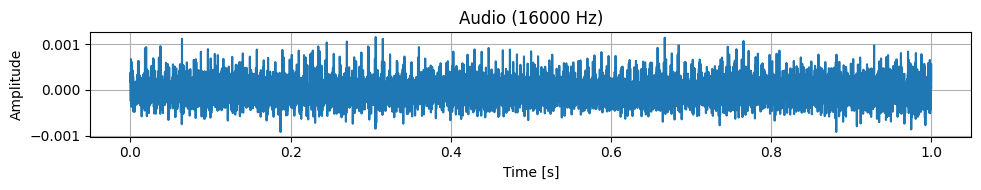

In [5]:
sample = chunked_data.audio[440]
sample.plot()

Augmentieren der Chunks durch das Hinzufügen von Bodenreflexionen

In [4]:
from augmentations import apply_ground_reflection_to_dataset

ranges = {
    "src_x": (-10, 10),
    "src_y": (-10, 10),
    "src_z": (1, 5),
    "mic_z": (1, 2),
    "attenuation": (0.05, 0.95)
}

augmented_data = apply_ground_reflection_to_dataset(
    dataset=chunked_data,
    sample_rate=config["sample_rate"],
    ranges=ranges
)



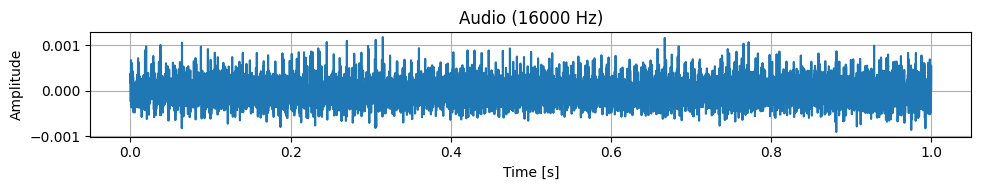

In [6]:
sample = augmented_data.audio[440]
sample.plot()

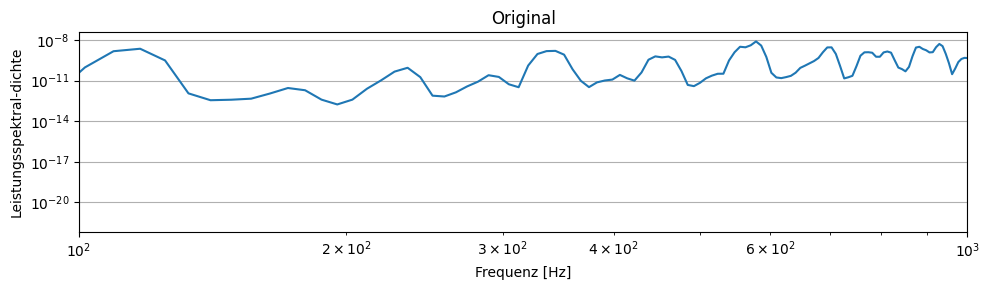

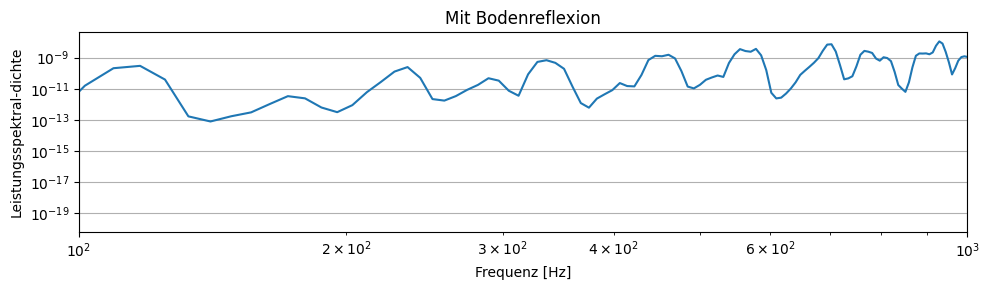

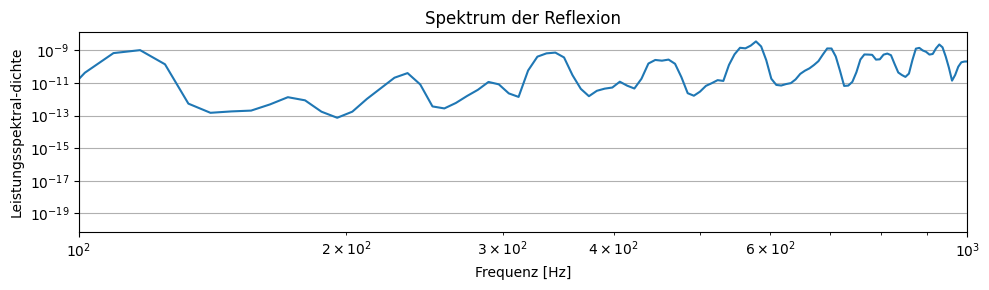

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum(signal, sample_rate, title="Spektrum", fmin=10, fmax=1000):
    from scipy.signal import welch
    freqs, psd = welch(signal, fs=sample_rate, nperseg=2048)
    plt.figure(figsize=(10, 3))
    plt.loglog(freqs, psd)
    plt.title(title)
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Leistungsspektral­dichte")
    plt.xlim(fmin, fmax)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

chunk_number = 447
original = chunked_data.audio[chunk_number].signal
augmented = augmented_data.audio[chunk_number].signal

plot_spectrum(original, config["sample_rate"], title="Original", fmin=100, fmax=1000)
plot_spectrum(augmented, config["sample_rate"], title="Mit Bodenreflexion", fmin=100, fmax=1000)

residual = augmented - original

plot_spectrum(residual, config["sample_rate"], title="Spektrum der Reflexion", fmin=100, fmax=1000)



Den Reflexionsanteil anschauen

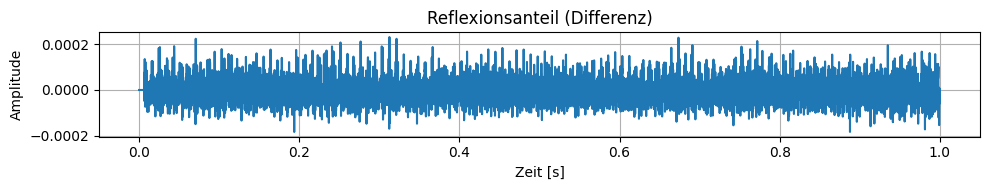

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, sample_rate, title="Signal"):
    duration = len(signal) / sample_rate
    time = np.linspace(0, duration, len(signal))
    plt.figure(figsize=(10, 2))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel("Zeit [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

original = chunked_data.audio[440].signal
augmented = augmented_data.audio[440].signal
residual = augmented - original
plot_signal(residual, config["sample_rate"], title="Reflexionsanteil (Differenz)")


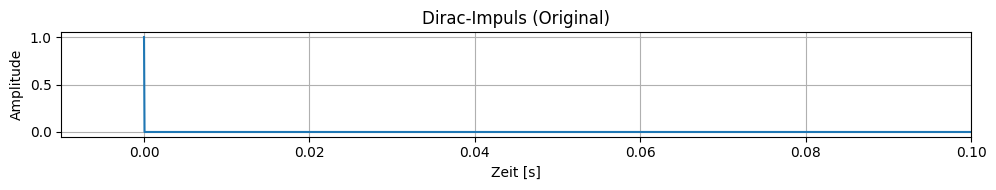

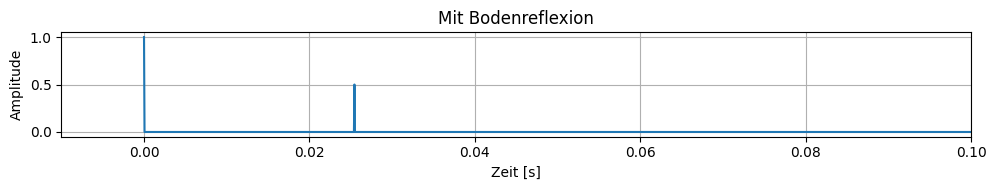

In [41]:
import numpy as np
from augmentations import simulate_ground_reflection
from plotting import plot_signal  # Falls du deine Plotfunktion so benannt/importiert hast
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, sample_rate, title="Signal"):
    duration = len(signal) / sample_rate
    time = np.linspace(0, duration, len(signal))
    plt.figure(figsize=(10, 2))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel("Zeit [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(-0.01, 0.1)
    plt.show()

# Testsignal: Dirac-Impuls
sample_rate = 16000  # z. B. 16 kHz
length = 16000       # 1 Sekunde
dirac = np.zeros(length, dtype=np.float32)
dirac[0] = 1.0        # Impuls bei t = 0

# Positionen realistisch wählen
src_pos = (20.0, 10.0, 40.0)   # Drohne
mic_pos = (0.0, 0.0, 5)   # Mikrofon

# Augmentierung ausführen
aug_signal = simulate_ground_reflection(
    signal=dirac,
    sample_rate=sample_rate,
    src_pos=src_pos,
    mic_pos=mic_pos,
    attenuation_range=(0.5, 0.5)  # fix zur besseren Sichtbarkeit
)

# Plot Original + Augmentiert
plot_signal(dirac, sample_rate, title="Dirac-Impuls (Original)")
plot_signal(aug_signal, sample_rate, title="Mit Bodenreflexion")


Features extrahieren


In [ ]:
features = FeatureSet(augmented_data, sample_rate=config["sample_rate"])
X, y = features.extract()
X.shape, len(y)


Modell Trainieren


In [ ]:
classifier = DroneClassifier(model_path=config["model_file"])
classifier.train(X, y, X, y)  # vorerst Training == Validation

classifier.summary()
classifier.evaluate(X, y)



Ausführung

In [ ]:
pipeline = TrainerPipeline(config)
pipeline.run()

In [ ]:
train_data = pipeline.load_or_generate_features.__self__.extractor  # oder direkter Zugriff via .extractor, .classifier

In [4]:
from augmentations import simulate_ground_reflection

aug = simulate_ground_reflection(chunked_data.audio[0].signal, sample_rate=config["sample_rate"])


TraitError: Cannot set the undefined 'signal' attribute of a 'TimeSamples' object.